In [1]:
import pyro
import torch
import normflows as nf
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
import yaml
import corner
import random
import pandas as pd
from collections import defaultdict
import numpy as np
mpl.rcParams["figure.dpi"] = 100

from grad_june import Runner

#torch.autograd.detect_anomaly(check_nan=True)

/cosma/home/dp004/dc-quer1/.conda/envs/ml/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = "cuda:3"

In [3]:
def set_random_seed(seed=999):
    """
    Sets global seeds for testing in numpy, random, and numbaized numpy.
    """
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    return
#set_random_seed()

In [4]:
def plot_posterior(nfm, param_names, lims=(0,2)):
    posteriors = nfm.sample(10000)
    samples = posteriors[0].cpu().detach().numpy()
    samples = np.where(~np.isnan(samples), samples, 0)
    samples = np.where(~np.isinf(samples), samples, 0)
    samples = np.where(np.abs(samples) < 5, samples, 0)
    f = corner.corner(samples, 
                      labels = param_names, 
                      smooth=2, 
                      show_titles=True,
                      bins=30,
                      range = [lims for i in range(len(param_names))])
    #f.savefig(f"./flow_results/posteriors/posterior_{it:03d}.png", dpi=150, facecolor='white')
    return

<AxesSubplot:>

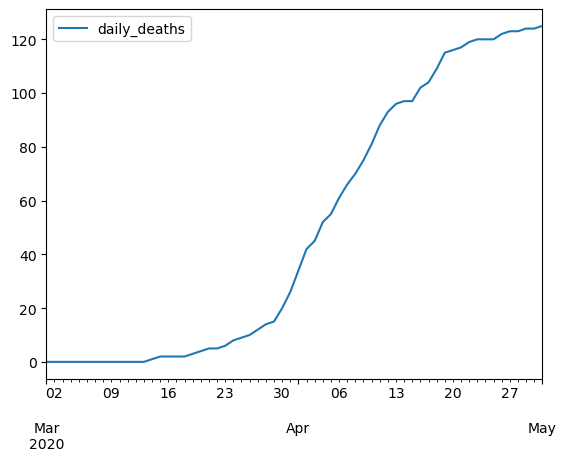

In [5]:
deaths_df = pd.read_csv("../deaths_by_lad.csv")
deaths_df = deaths_df.loc[deaths_df.area_name == "Camden"]
deaths_df = deaths_df.groupby("date").sum()["daily_deaths"].to_frame()
deaths_df.index = pd.to_datetime(deaths_df.index)

date_range = pd.date_range(start="2020-03-01", end="2020-05-01")
data_df = pd.DataFrame(index=date_range)
data_df["daily_deaths"] = 0
for date in date_range:
    if date in deaths_df.index:
        data_df.loc[date, "daily_deaths"] = deaths_df.loc[date, "daily_deaths"]
data_df = data_df.cumsum()
data_df.plot()


In [6]:
#params = yaml.safe_load(open("../configs/june.yaml"))
params_to_calibrate = ["household", "school", "company", "university", "grocery"]#, "log_fraction_initial_cases"]
n_params = len(params_to_calibrate)
params = yaml.safe_load(open("../configs/tests.yaml"))
params["timer"]["total_days"] = len(data_df) - 1
params["timer"]["initial_day"] = "2020-03-01"
params["system"]["device"] = device
#params["data_path"] = "/cosma/home/dp004/dc-quer1/gradabm-june/test/data/data.pkl"
params["data_path"] = "/cosma7/data/dp004/dc-quer1/torch_june_worlds/data_camden.pkl"
runner = Runner.from_parameters(params)
runner()
test_deaths = runner.data['results']['daily_deaths']

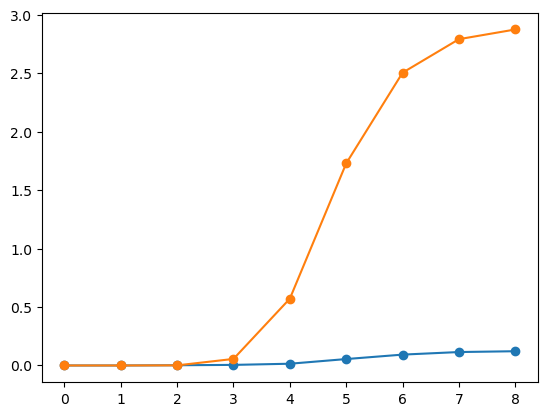

In [7]:
true_data = torch.tensor(data_df.values, device=device).flatten() / 1000 # / runner.n_agents * 100
plt.plot(true_data[::7].cpu(), "o-")
plt.plot(test_deaths[::7].cpu() / 1000, "o-")
#plt.yscale("log")

In [8]:
prior = torch.distributions.Normal(torch.ones(n_params, device=device), torch.ones(n_params, device=device))

/cosma/home/dp004/dc-quer1/.conda/envs/ml/lib/python3.9/site-packages/normflows/flows/mixing.py:437: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /opt/conda/conda-bld/pytorch_1659484806139/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:2183.)
  outputs, _ = torch.triangular_solve(


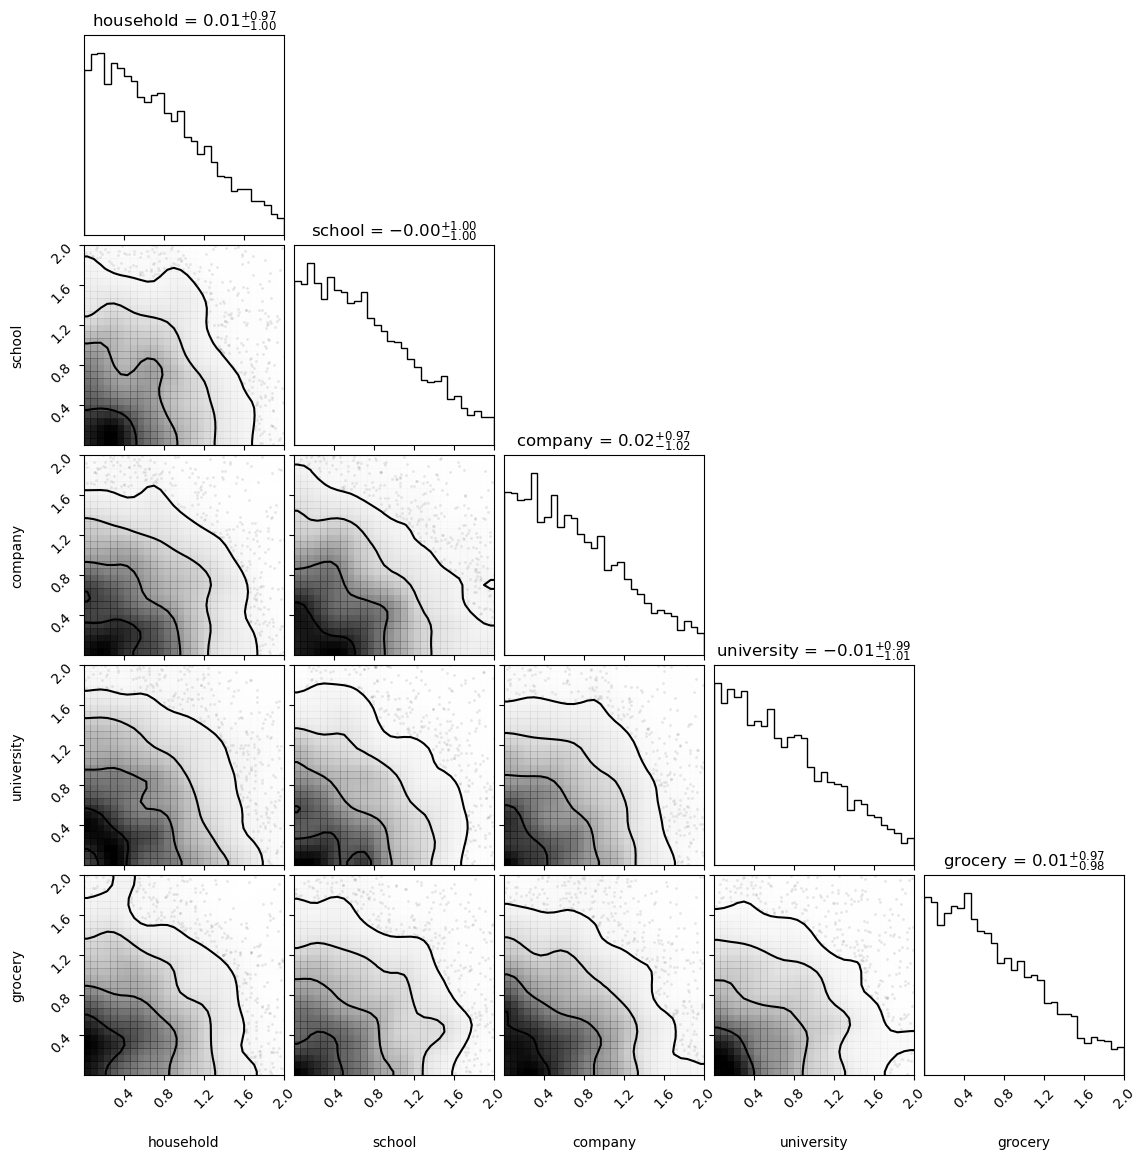

In [9]:
# Set up model

# Define flows
K = 8

latent_size = n_params
hidden_units = 32
hidden_layers = 2

flows = []
for i in range(K):
    flows += [nf.flows.AutoregressiveRationalQuadraticSpline(latent_size, hidden_layers, hidden_units)]
    flows += [nf.flows.LULinearPermute(latent_size)]

# Set prior and q0
q0 = nf.distributions.DiagGaussian(n_params, trainable=False)

# Construct flow model
flow = nf.NormalizingFlow(q0=q0, flows=flows)

# Move model on GPU if available
flow = flow.to(device)

plot_posterior(flow, param_names = params_to_calibrate)
plt.show()

In [10]:
def run_model(runner, sample):
    #print(sample)
    sample = sample.flatten()
    for (j, name) in enumerate(params_to_calibrate):
        if name == "log_fraction_initial_cases":
            runner.log_fraction_initial_cases = torch.minimum(torch.tensor(0.0), sample[j])
            print(sample[j])
        else:
            runner.model.infection_networks.networks[name].log_beta = sample[j]
    _ = runner()
    daily_deaths = runner.data["results"]["daily_deaths"] / 1000 #/ runner.n_agents * 100
    return daily_deaths

def get_forecast_score(flow, true_data, loss_fn, n_samples=5):
    loss = 0.0
    for i in range(n_samples):
        sample, lp = flow.sample()
        daily_deaths = run_model(runner, sample)
        print(daily_deaths)
        print(true_data)
        print("--")
        loss_i = loss_fn(daily_deaths, true_data)
        loss_i.backward()
        loss += loss_i
    return loss / n_samples

def get_regularisation(flow, n_samples=5):
    samples, flow_lps = flow.sample(n_samples)
    prior_lps = prior.log_prob(samples).sum(1)
    kl = torch.mean(flow_lps - prior_lps)
    return kl


In [11]:
losses = defaultdict(list)
best_loss = np.inf

In [ ]:
# Train model

parameters_to_optimize = list(flow.parameters())
print(sum([len(a) for a in parameters_to_optimize]))
optimizer = torch.optim.Adam(parameters_to_optimize, lr=5e-4)
loss_fn = torch.nn.MSELoss(reduction="mean")


n_epochs = 10000
n_samples_per_epoch = 10
n_samples_reg = 10


w = 0.0 #torch.tensor(1.0, requires_grad=True)

iterator = tqdm(range(n_epochs))

for it in iterator:
    optimizer.zero_grad()
    forecast_loss = get_forecast_score(flow=flow, true_data=true_data, loss_fn=loss_fn, n_samples=n_samples_per_epoch)
    reglrise_loss = get_regularisation(flow=flow, n_samples=n_samples_reg)
    loss = forecast_loss  + w * reglrise_loss
    losses["forecast_train"].append(forecast_loss.item())
    losses["reglrise_train"].append(reglrise_loss.item())
    #print(loss)
    if torch.isnan(loss):
        print("loss is nan!")
        break
    #loss.backward()

    optimizer.step()
    if loss.item() < best_loss:
        torch.save(flow.state_dict(), "./best_model_data.pth")
        best_loss = loss.item()
    
    #with torch.no_grad():
    #    val_forecast_loss = get_forecast_score(flow=flow, true_data=true_data, loss_fn=loss_fn, n_samples=n_samples_per_epoch)
    #    val_reglrise_loss = get_regularisation(flow=flow, n_samples=n_samples_reg)
    #    val_loss = val_forecast_loss + w * val_reglrise_loss
    #    
    #    losses["forecast_val"].append(val_forecast_loss.item())
    #    losses["reglrise_val"].append(val_reglrise_loss.item())
#
    #    if val_loss.item() < best_loss:
    #        torch.save(flow.state_dict(), "./best_model_data.pth")
    #        best_loss = val_loss.item()
    #    iterator.set_postfix({"fl":forecast_loss.item(), 
    #                          "rl":reglrise_loss.item(), 
    #                          "val loss":val_loss.item(), 
    #                          "best val loss":best_loss})
    df = pd.DataFrame(losses)
    df.to_csv("./losses_data.csv")

4640


  0%|                                                              | 0/10000 [00:00<?, ?it/s]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0010, 0.0010, 0.0030, 0.0050, 0.0100, 0.0130, 0.0170, 0.0240, 0.0300,
        0.0400, 0.0510, 0.0640, 0.0820, 0.0990, 0.1130, 0.1330, 0.1540, 0.1740,
        0.2010, 0.2140, 0.2440, 0.2700, 0.2960, 0.3250, 0.3390, 0.3580, 0.3760,
        0.3910, 0.4110, 0.4220, 0.4270, 0.4380, 0.4450, 0.4530, 0.4600, 0.4670,
        0.4710, 0.4770, 0.4810, 0.4830, 0.4860, 0.4870, 0.4890, 0.4900],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                   | 1/10000 [00:19<55:09:22, 19.86s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0010,
        0.0020, 0.0020, 0.0020, 0.0040, 0.0040, 0.0080, 0.0100, 0.0100, 0.0130,
        0.0150, 0.0170, 0.0210, 0.0250, 0.0360, 0.0400, 0.0480, 0.0530, 0.0640,
        0.0770, 0.0820, 0.0910, 0.1010, 0.1090, 0.1220, 0.1290, 0.1370, 0.1470,
        0.1560, 0.1650, 0.1760, 0.1820, 0.1930, 0.1990, 0.2060, 0.2110, 0.2150,
        0.2210, 0.2240, 0.2290, 0.2330, 0.2370, 0.2390, 0.2390, 0.2410],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                   | 2/10000 [00:37<51:15:32, 18.46s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0010,
        0.0020, 0.0020, 0.0020, 0.0020, 0.0020, 0.0030, 0.0040, 0.0050, 0.0060,
        0.0060, 0.0070, 0.0090, 0.0100, 0.0120, 0.0130, 0.0130, 0.0140, 0.0140,
        0.0160, 0.0170, 0.0180, 0.0180, 0.0180, 0.0180, 0.0190, 0.0190, 0.0200,
        0.0200, 0.0200, 0.0210, 0.0210, 0.0210, 0.0220, 0.0220, 0.0220, 0.0220,
        0.0230, 0.0230, 0.0230, 0.0230, 0.0230, 0.0230, 0.0230, 0.0230],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                   | 3/10000 [00:54<49:48:30, 17.94s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0020, 0.0020, 0.0030, 0.0030, 0.0040, 0.0040, 0.0040, 0.0040,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                   | 4/10000 [01:10<47:41:36, 17.18s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0020, 0.0030, 0.0060, 0.0060, 0.0060, 0.0060,
        0.0100, 0.0110, 0.0110, 0.0120, 0.0130, 0.0130, 0.0130, 0.0130, 0.0140,
        0.0170, 0.0180, 0.0200, 0.0210, 0.0230, 0.0230, 0.0260, 0.0260, 0.0270,
        0.0290, 0.0300, 0.0300, 0.0300, 0.0300, 0.0310, 0.0310, 0.0310, 0.0310,
        0.0310, 0.0310, 0.0310, 0.0310, 0.0310, 0.0310, 0.0310, 0.0310],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                   | 5/10000 [01:26<46:33:37, 16.77s/it]

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e-03, 1.0000e-03,
        3.0000e-03, 5.0000e-03, 7.0000e-03, 1.4000e-02, 2.4000e-02, 4.2000e-02,
        6.9000e-02, 1.0300e-01, 1.2900e-01, 1.8000e-01, 2.2900e-01, 2.9000e-01,
        3.4800e-01, 4.3400e-01, 5.2800e-01, 6.1100e-01, 6.9900e-01, 7.7700e-01,
        8.5500e-01, 9.3400e-01, 9.9200e-01, 1.0520e+00, 1.1160e+00, 1.1790e+00,
        1.2450e+00, 1.2950e+00, 1.3480e+00, 1.3820e+00, 1.4130e+00, 1.4460e+00,
        1.4660e+00, 1.4870e+00, 1.5080e+00, 1.5230e+00, 1.5370e+00, 1.5490e+00,
        1.5600e+00, 1.5650e+00, 1.5740e+00, 1.5830e+00, 1.5870e+00, 1.5900e+00,
        1.5950e+00, 1.5980e+00], device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010

  0%|                                                   | 6/10000 [01:42<45:41:50, 16.46s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0020, 0.0020, 0.0020, 0.0030, 0.0030, 0.0040, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0060, 0.0070, 0.0070, 0.0070, 0.0080, 0.0090, 0.0110, 0.0120,
        0.0140, 0.0150, 0.0160, 0.0160, 0.0170, 0.0170, 0.0180, 0.0210, 0.0210,
        0.0210, 0.0210, 0.0210, 0.0210, 0.0210, 0.0210, 0.0220, 0.0220, 0.0220,
        0.0220, 0.0220, 0.0220, 0.0220, 0.0220, 0.0220, 0.0220, 0.0220],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                   | 7/10000 [01:58<45:14:35, 16.30s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0020, 0.0030, 0.0040, 0.0050,
        0.0060, 0.0060, 0.0090, 0.0110, 0.0120, 0.0130, 0.0140, 0.0150, 0.0170,
        0.0200, 0.0220, 0.0230, 0.0270, 0.0290, 0.0320, 0.0330, 0.0360, 0.0390,
        0.0410, 0.0430, 0.0440, 0.0450, 0.0480, 0.0490, 0.0530, 0.0560, 0.0560,
        0.0570, 0.0600, 0.0620, 0.0630, 0.0640, 0.0640, 0.0640, 0.0650, 0.0650,
        0.0670, 0.0680, 0.0680, 0.0680, 0.0680, 0.0680, 0.0690, 0.0690],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                   | 8/10000 [02:14<44:52:57, 16.17s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0010,
        0.0030, 0.0030, 0.0030, 0.0030, 0.0040, 0.0060, 0.0060, 0.0070, 0.0070,
        0.0070, 0.0080, 0.0080, 0.0090, 0.0110, 0.0110, 0.0120, 0.0120, 0.0120,
        0.0120, 0.0120, 0.0120, 0.0140, 0.0140, 0.0140, 0.0140, 0.0140, 0.0140,
        0.0140, 0.0150, 0.0150, 0.0150, 0.0150, 0.0150, 0.0150, 0.0150, 0.0150,
        0.0150, 0.0150, 0.0150, 0.0150, 0.0150, 0.0150, 0.0150, 0.0150],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                   | 9/10000 [02:30<44:42:28, 16.11s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0010,
        0.0010, 0.0010, 0.0010, 0.0010, 0.0010, 0.0030, 0.0040, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0060, 0.0060, 0.0060, 0.0060, 0.0070,
        0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070,
        0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070,
        0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                  | 10/10000 [02:46<44:22:40, 15.99s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020,
        0.0030, 0.0030, 0.0030, 0.0030, 0.0030, 0.0030, 0.0030, 0.0060, 0.0070,
        0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0080, 0.0080, 0.0080,
        0.0080, 0.0080, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
        0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
        0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                  | 11/10000 [03:01<44:14:40, 15.95s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0010, 0.0020,
        0.0020, 0.0020, 0.0030, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040,
        0.0040, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                  | 12/10000 [03:17<44:06:37, 15.90s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0010, 0.0010, 0.0030, 0.0060, 0.0080, 0.0090, 0.0100, 0.0110,
        0.0140, 0.0160, 0.0190, 0.0200, 0.0210, 0.0280, 0.0300, 0.0330, 0.0340,
        0.0370, 0.0410, 0.0440, 0.0470, 0.0480, 0.0500, 0.0550, 0.0610, 0.0620,
        0.0660, 0.0710, 0.0740, 0.0760, 0.0790, 0.0850, 0.0870, 0.0900, 0.0900,
        0.0900, 0.0920, 0.0920, 0.0920, 0.0930, 0.0930, 0.0950, 0.0950],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                  | 13/10000 [03:33<44:02:00, 15.87s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0010, 0.0010, 0.0010, 0.0030, 0.0040, 0.0050, 0.0050,
        0.0050, 0.0060, 0.0060, 0.0060, 0.0070, 0.0080, 0.0080, 0.0090, 0.0090,
        0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
        0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090,
        0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090, 0.0090],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                  | 14/10000 [03:49<43:56:28, 15.84s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0010, 0.0010, 0.0010, 0.0020, 0.0020, 0.0030, 0.0030, 0.0030,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050, 0.0050,
        0.0050, 0.0050, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060,
        0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060,
        0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                  | 15/10000 [04:05<43:55:22, 15.84s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0020, 0.0020, 0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0060,
        0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0070, 0.0070, 0.0070, 0.0070,
        0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070,
        0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070,
        0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                  | 16/10000 [04:21<43:57:20, 15.85s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0030, 0.0030,
        0.0030, 0.0030, 0.0030, 0.0040, 0.0040, 0.0040, 0.0050, 0.0050, 0.0070,
        0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0070, 0.0080, 0.0080, 0.0080,
        0.0080, 0.0080, 0.0080, 0.0080, 0.0080, 0.0080, 0.0080, 0.0080, 0.0080,
        0.0080, 0.0080, 0.0080, 0.0080, 0.0080, 0.0080, 0.0080, 0.0080],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                  | 17/10000 [04:36<43:59:48, 15.87s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0030,
        0.0050, 0.0060, 0.0100, 0.0130, 0.0170, 0.0260, 0.0290, 0.0380, 0.0410,
        0.0470, 0.0520, 0.0560, 0.0620, 0.0660, 0.0700, 0.0730, 0.0760, 0.0770,
        0.0800, 0.0810, 0.0830, 0.0870, 0.0910, 0.0930, 0.0930, 0.0930, 0.0930,
        0.0950, 0.0950, 0.0950, 0.0960, 0.0970, 0.0970, 0.0980, 0.0980, 0.0980,
        0.0980, 0.0980, 0.0980, 0.0990, 0.0990, 0.0990, 0.0990, 0.1000],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                  | 18/10000 [04:52<43:55:37, 15.84s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0010, 0.0020,
        0.0030, 0.0030, 0.0030, 0.0030, 0.0050, 0.0060, 0.0060, 0.0070, 0.0070,
        0.0070, 0.0080, 0.0080, 0.0080, 0.0090, 0.0100, 0.0100, 0.0100, 0.0100,
        0.0100, 0.0100, 0.0100, 0.0100, 0.0110, 0.0120, 0.0120, 0.0120, 0.0120,
        0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120,
        0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120, 0.0120],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                  | 19/10000 [05:08<44:00:51, 15.88s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0010,
        0.0020, 0.0030, 0.0040, 0.0040, 0.0050, 0.0050, 0.0060, 0.0060, 0.0060,
        0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060,
        0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060,
        0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060,
        0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060, 0.0060],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                  | 20/10000 [05:24<43:57:05, 15.85s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0010, 0.0020, 0.0020,
        0.0040, 0.0050, 0.0070, 0.0150, 0.0220, 0.0290, 0.0390, 0.0520, 0.0570,
        0.0720, 0.0970, 0.1150, 0.1360, 0.1520, 0.1680, 0.1940, 0.2130, 0.2300,
        0.2640, 0.2830, 0.2990, 0.3160, 0.3340, 0.3560, 0.3700, 0.3790, 0.3880,
        0.3990, 0.4020, 0.4060, 0.4080, 0.4110, 0.4130, 0.4150, 0.4180, 0.4200,
        0.4220, 0.4240, 0.4250, 0.4270, 0.4270, 0.4310, 0.4310, 0.4310],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

  0%|                                                  | 21/10000 [05:40<43:56:24, 15.85s/it]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0010, 0.0020, 0.0020, 0.0040,
        0.0050, 0.0070, 0.0070, 0.0080, 0.0080, 0.0080, 0.0090, 0.0090, 0.0090,
        0.0090, 0.0090, 0.0090, 0.0110, 0.0120, 0.0130, 0.0130, 0.0130, 0.0130,
        0.0130, 0.0130, 0.0130, 0.0130, 0.0130, 0.0130, 0.0130, 0.0130, 0.0130,
        0.0130, 0.0140, 0.0140, 0.0140, 0.0140, 0.0140, 0.0140, 0.0140, 0.0140,
        0.0140, 0.0140, 0.0140, 0.0140, 0.0140, 0.0140, 0.0140, 0.0140],
       device='cuda:3', grad_fn=<DivBackward0>)
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0010, 0.0020, 0.0020, 0.0020, 0.0020,
        0.0030, 0.0040, 0.0050, 0.0050, 0.0060, 0.0080, 0.0090, 0.0100, 0.0120,
        0.0140, 0.0150, 0.0200, 0.0260, 0.0340, 0.0420, 0.0450, 0.0520, 0.0550,
        0.0610, 0.0660, 0.0700, 0.0750, 0.0810, 0.0880, 0.0930, 0.0960, 0.0970,

In [ ]:
flow.load_state_dict(torch.load("./best_model_data.pth"))

In [ ]:
plot_posterior(flow, params_to_calibrate, lims=(-5, 2))

In [ ]:
n_plot = 5
fig, ax = plt.subplots()

for i in range(n_plot):
    with torch.no_grad():
        params["system"]["device"] = device
        params["data_path"] = "/cosma7/data/dp004/dc-quer1/torch_june_worlds/data_camden.pkl"
        runner = Runner.from_parameters(params)
        best_params_sample, log_prob = flow.sample()
        cases = run_model(runner, best_params_sample)
        ax.plot(cases.detach().cpu())

ax.plot(true_data.cpu(), color = "black", linewidth=2)
#ax.set_yscale("log")